In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip utkface-new.zip

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [8]:
width = height = 224

In [9]:
images = [] # X
ages = [] # Y

for image_name in os.listdir("crop_part1"):
    parts = image_name.split("_")
    age = int(parts[0])
    ages.append(age)

    image = cv2.imread("crop_part1/" + image_name)
    image = cv2.resize(image, (width,height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [10]:
images = pd.Series(images, name="Images")
ages = pd.Series(ages, name="Ages")

df = pd.concat([images,ages],axis=1)
df.head()

,Images,Ages
0,"[[[25, 13, 0], [27, 15, 0], [31, 18, 2], [31, ...",23
1,"[[[94, 82, 70], [95, 83, 71], [94, 82, 70], [9...",53
2,"[[[30, 26, 17], [31, 27, 18], [30, 27, 19], [3...",14
3,"[[[95, 82, 63], [87, 74, 55], [81, 66, 47], [7...",49
4,"[[[101, 80, 61], [98, 77, 58], [99, 77, 59], [...",69


53


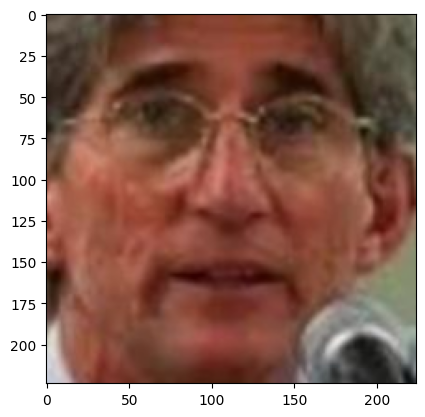

In [11]:
print(df["Ages"][1])
plt.imshow(df["Images"][1])
plt.show()

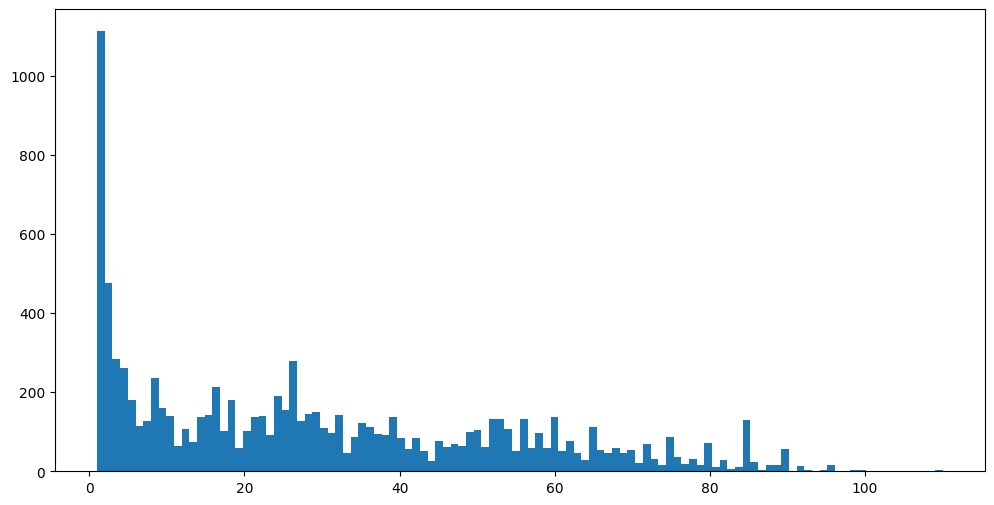

In [12]:
plt.figure(figsize=(12,6))
plt.hist(df["Ages"],bins=df["Ages"].max())
plt.show()

In [13]:
under_4 = df[df["Ages"] <= 4 ]
up_4 = df[df["Ages"] > 4 ]

under_4 = under_4.sample(frac=0.3)

df = pd.concat([under_4,up_4],axis=0)

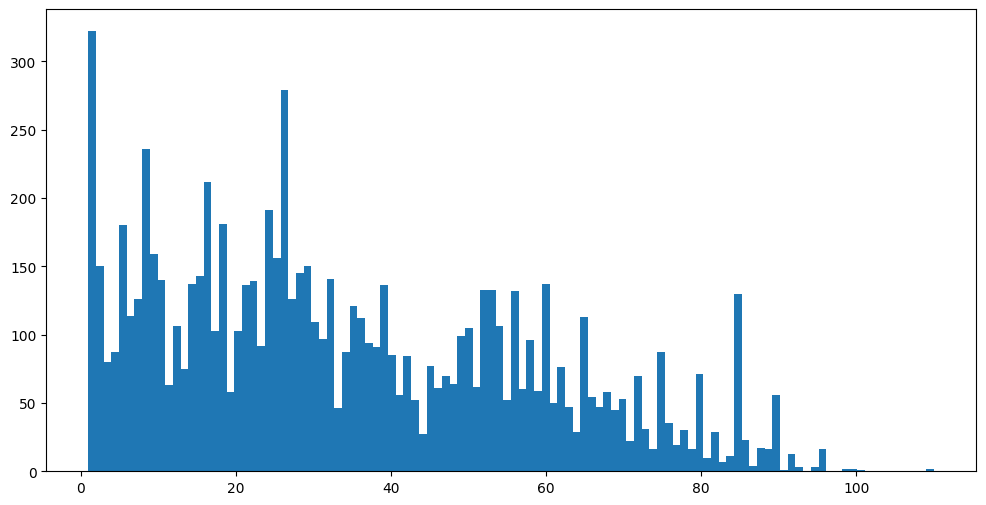

In [14]:
plt.figure(figsize=(12,6))
plt.hist(df["Ages"],bins=df["Ages"].max())
plt.show()

In [15]:
df = df[df["Ages"] < 80]

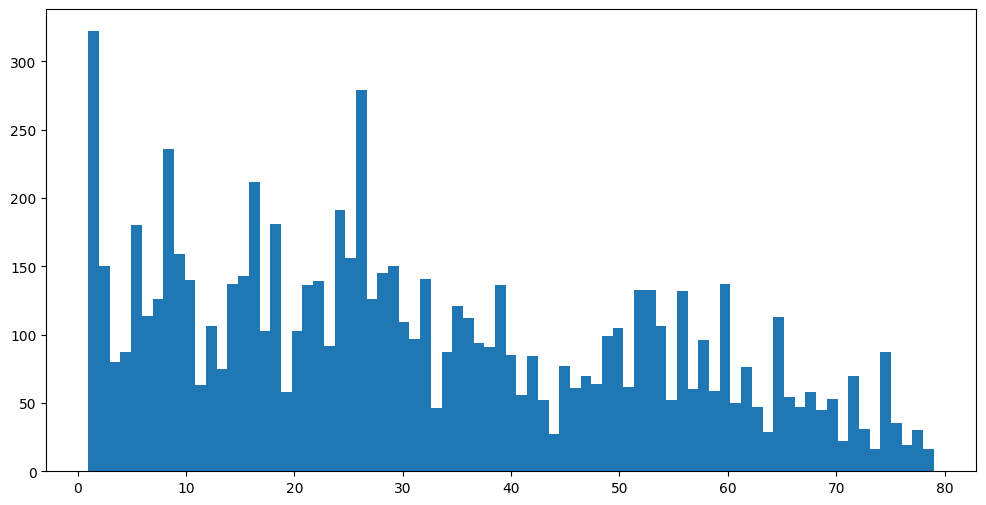

In [16]:
plt.figure(figsize=(12,6))
plt.hist(df["Ages"],bins=df["Ages"].max())
plt.show()

In [17]:
# convert from pandas dataframe to numpy array
X = np.array(df["Images"].values.tolist())
Y = np.array(df["Ages"].values.tolist())

In [18]:
X.shape

(7871, 224, 224, 3)

In [19]:
Y.shape

(7871,)

In [20]:
X_train , X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2)

In [21]:
print(X_train.shape ,"\n", X_validation.shape ,"\n", Y_train.shape ,"\n", Y_validation.shape)

(6296, 224, 224, 3) 
 (1575, 224, 224, 3) 
 (6296,) 
 (1575,)


In [23]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

train_data = image_data_generator.flow(X_train,
                                       Y_train,
                                       batch_size=32,
                                       shuffle=True)

train_data = image_data_generator.flow(X_validation,
                                       Y_validation,
                                       batch_size=16,
                                       shuffle=False)

### Creat Model

In [24]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3),
    pooling="avg",
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable = False # Freeze

In [29]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="relu")
])

In [30]:
del X
del Y
del df
del images
del ages
del under_4
del up_4

In [31]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError,
              optimizer=tf.keras.optimizers.Adam())

In [32]:
model.fit(train_data,validation_data=train_data,epochs=20)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - loss: 25.0410 - val_loss: 16.7436
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 15.6867 - val_loss: 15.4331
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 15.0638 - val_loss: 14.4348
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 14.3486 - val_loss: 13.5783
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 13.7910 - val_loss: 13.0264
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 13.3604 - val_loss: 12.5052
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 13.0440 - val_loss: 12.2491
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 12.6867 - val_loss: 11.9931
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 12.0070 - val_loss: 11.7423
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 12.3002 - val_loss: 11.5651
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 11.9045 - val_loss: 11.4024
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/ste